# Variant regulatory consequence analysis

This notebook introduces new dataset `Epiraction`, which contains the regulatory consequences for variants.

## Epiraction dataset ingesion

In [1]:
from __future__ import annotations

from pathlib import Path

import hail as hl
from gentropy.common.session import Session


Loading BokehJS ...

In [2]:
hail_home = Path(hl.__file__).parent.as_posix()
session = Session(
    extended_spark_conf={"spark.driver.memory": "120G"},
    start_hail=True,
    hail_home=hail_home,
)
dataset_path = "/home/mindos/data/epiraction_v1.6"


pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/backend/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/backend/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 3.5.5
SparkUI available at http://192.168.0.100:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.134-952ae203dbbe
LOGGING: writing to /dev/null


In [3]:
session.spark


In [ ]:
df = session.spark.read.parquet(dataset_path)


In [ ]:
df.printSchema()


root
 |-- chromosome: string (nullable = true)
 |-- start: string (nullable = true)
 |-- end: string (nullable = true)
 |-- geneId: string (nullable = true)
 |-- biosampleName: string (nullable = true)
 |-- intervalType: string (nullable = true)
 |-- score: double (nullable = true)
 |-- resourceScore: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- value: float (nullable = true)
 |-- datasourceId: string (nullable = true)
 |-- pmid: string (nullable = true)



In [9]:
# Show all chromosomes
df.select("chromosome").distinct().orderBy("chromosome").show()


+----------+
|chromosome|
+----------+
|      chr1|
|     chr10|
|     chr11|
|     chr12|
|     chr13|
|     chr14|
|     chr15|
|     chr16|
|     chr17|
|     chr18|
|     chr19|
|      chr2|
|     chr20|
|     chr21|
|     chr22|
|      chr3|
|      chr4|
|      chr5|
|      chr6|
|      chr7|
+----------+
only showing top 20 rows




No mitochondrial chromosome found

In [ ]:
df.select("geneId").distinct().count()


24857

In [ ]:
df.select("biosampleName").distinct().count()


78

In [ ]:
df.select("intervalType").distinct().orderBy("intervalType").show()


+------------+
|intervalType|
+------------+
|    enhancer|
|    promoter|
+------------+



In [ ]:
df.select("score").describe().show()


+-------+--------------------+
|summary|               score|
+-------+--------------------+
|  count|           251777418|
|   mean|0.004735535229663087|
| stddev|0.020850645747324287|
|    min|           8.2381E-6|
|    max|                 1.0|
+-------+--------------------+



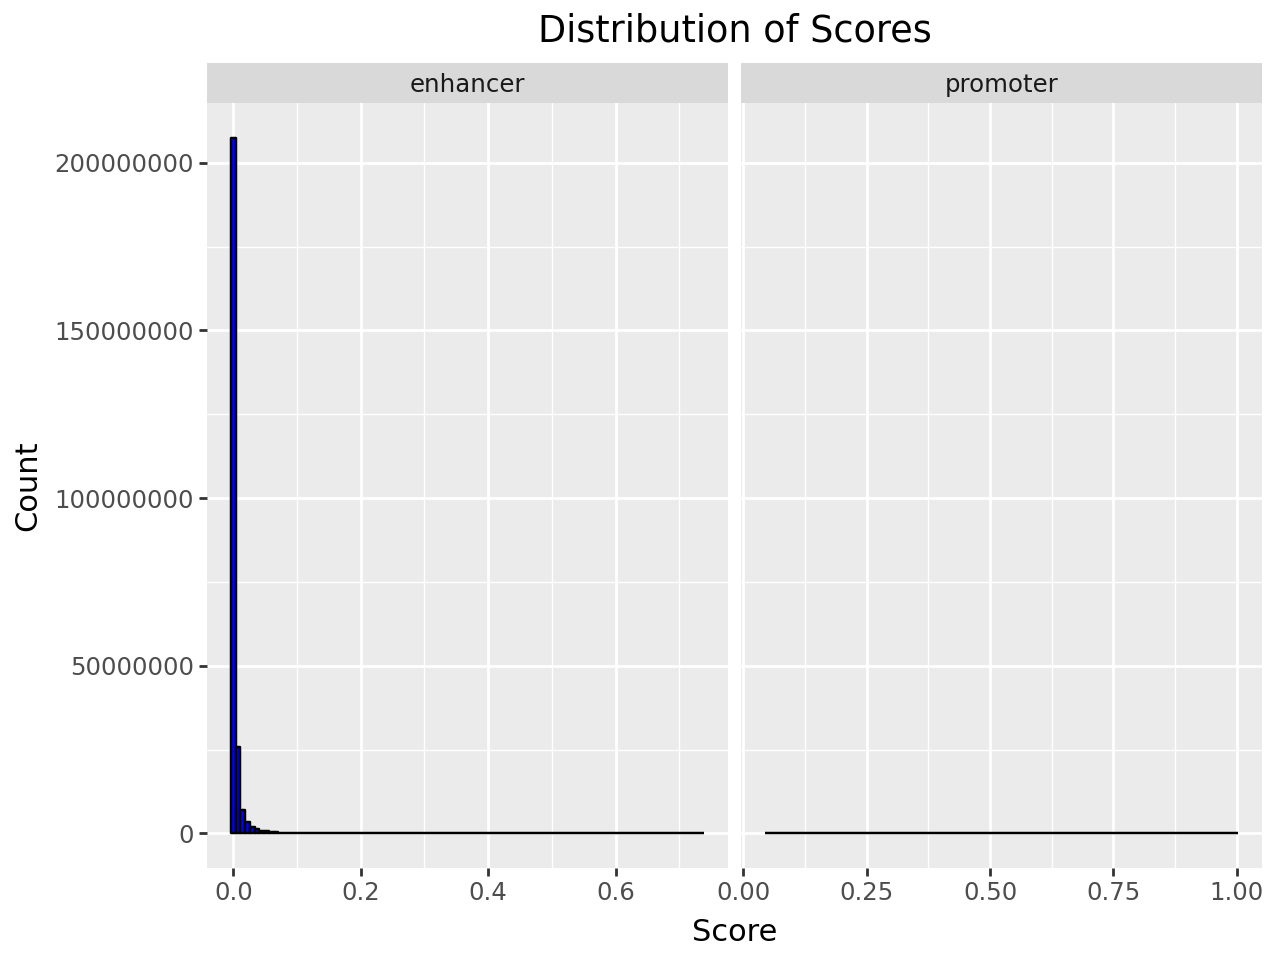

In [ ]:
import plotnine as p9
import pandas as pd

data = df.select("score", "intervalType").write.mode("overwrite").parquet("epiraction_scores.parquet")
data = pd.read_parquet("epiraction_scores.parquet/")

plot = (
    p9.ggplot(data, p9.aes(x="score", fill="intervalType"))
    + p9.geom_histogram(bins=100, fill="blue", color="black")
    + p9.labs(title="Distribution of Scores", x="Score", y="Count")
    + p9.facet_grid(cols="intervalType", scales="free")
)
plot


+------------+-------+-----+
|intervalType|  count|    %|
+------------+-------+-----+
|    enhancer|1093160|97.78|
|    promoter|  24829| 2.22|
+------------+-------+-----+



/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 1089255 rows containing non-finite values.
/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.


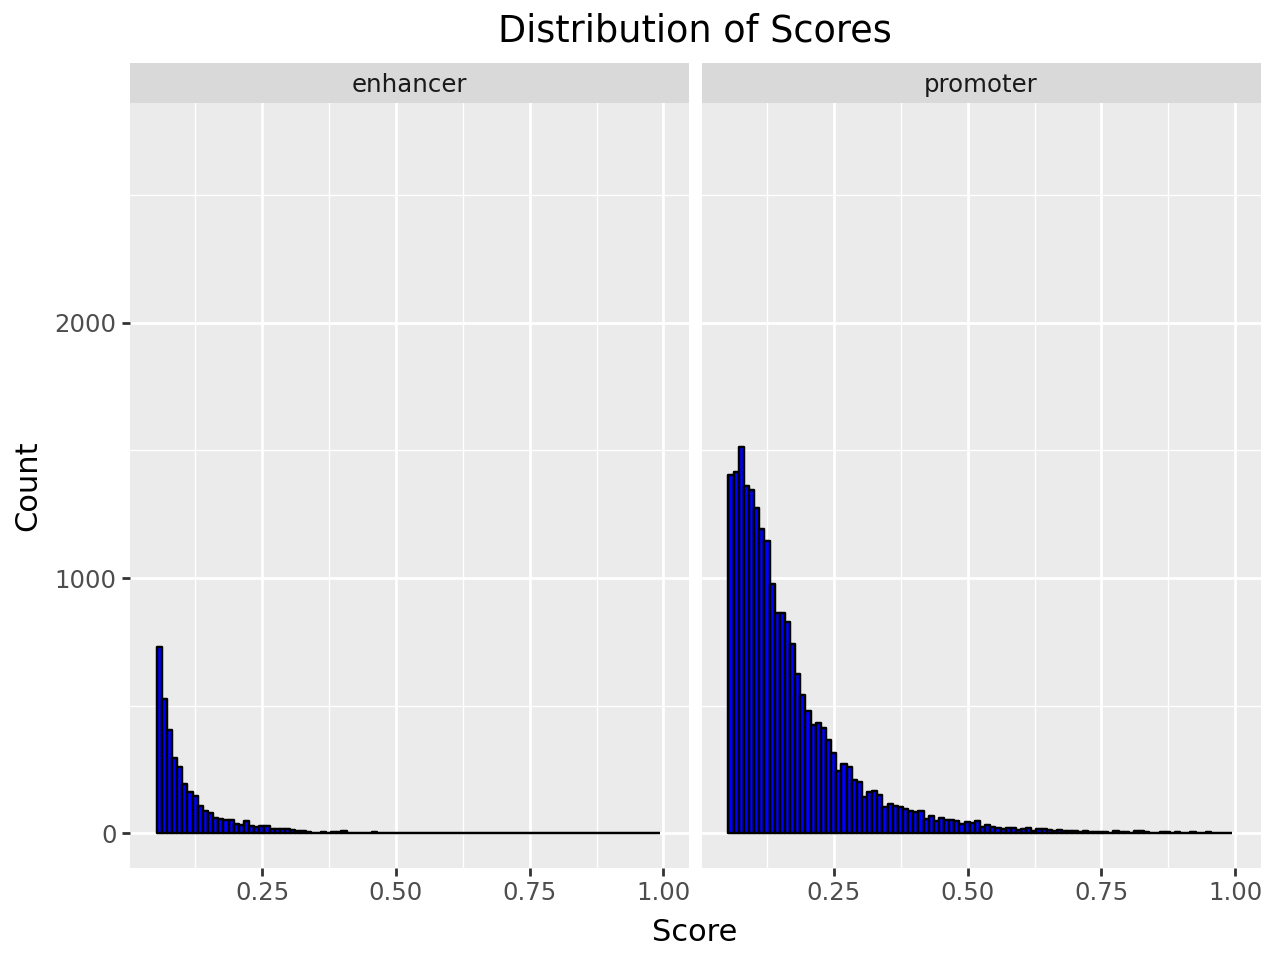

In [ ]:
import plotnine as p9
import pandas as pd
from manuscript_methods import group_statistics

_data = df.drop_duplicates(["start", "end", "intervalType"]).select("score", "intervalType")
_data.write.mode("overwrite").parquet("epiraction_scores.parquet")
data = pd.read_parquet("epiraction_scores.parquet/")

plot = (
    p9.ggplot(data, p9.aes(x="score", fill="intervalType"))
    + p9.geom_histogram(bins=100, fill="blue", color="black")
    + p9.labs(title="Distribution of Scores", x="Score", y="Count")
    + p9.facet_grid(cols="intervalType", scales="free")
    + p9.xlim(0.05, 1.00)
)
group_statistics(_data, "intervalType").show()
plot


In [33]:
from pyspark.sql import functions as f

df.filter(f.col("intervalType") == "promoter").groupBy("geneId").count().orderBy(f.desc("count")).filter(
    f.col("count") > 1
).show(10)


+---------------+-----+
|         geneId|count|
+---------------+-----+
|ENSG00000197930|   78|
|ENSG00000110442|   78|
|ENSG00000073536|   78|
|ENSG00000182054|   78|
|ENSG00000029364|   78|
|ENSG00000149541|   78|
|ENSG00000092201|   78|
|ENSG00000132773|   78|
|ENSG00000215021|   78|
|ENSG00000002016|   78|
+---------------+-----+
only showing top 10 rows



In [ ]:
# Check how many enhancers are associated with single gene
data = (
    df.filter(f.col("intervalType") == "enhancer")
    .filter(f.col("score") > 0.05)
    .groupBy("geneId")
    .count()
    .orderBy(f.asc("count"))
    .filter(f.col("count") > 1)
    .toPandas()
)

data.describe()


,count
count,24176.000000
mean,124.689651
std,102.060634
min,2.000000
25%,30.000000
50%,111.000000
75%,197.000000
max,616.000000


In [ ]:
session.spark.stop()
